In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import os
import time

# --- 1. Configuration ---
# Define the core parameters for the project
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = 4
BASE_DATA_DIR = './lsun_organized_resnext'
EPOCHS_STAGE_1 = 10 # Feature Extraction
EPOCHS_STAGE_2 = 20 # Fine-Tuning

print("✅ Configuration Set:")
print(f"   Image Size (IMG_SIZE): {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch Size (BATCH_SIZE): {BATCH_SIZE}")

# --- 2. System and GPU Check ---
print("\n🔍 Verifying System Status (TensorFlow/GPU)...")

# Check TensorFlow Version
print(f"   TensorFlow Version: {tf.__version__}")

# Check GPU Status
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Print detected GPU information
        print(f"   🔥 GPU Detected: {len(gpus)} physical device(s)")
        print(f"   Device Name: {gpus[0].name} (VRAM check must be done manually, but 11GB is excellent!)")
        
        # Check if TensorFlow is configured to use the GPU (logical devices)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"   Logical GPUs Configured: {len(logical_gpus)}")
        
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(f"   ⚠️ Runtime Error during GPU setup: {e}")
        
    # Test for basic device placement
    start_time = time.time()
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c = tf.matmul(a, b)
    end_time = time.time()
    print(f"   GPU Test (MatMul) successful. Time: {end_time - start_time:.4f}s")
    
else:
    print("   ⚠️ No GPU detected. TensorFlow will run on CPU.")

print("\n🚀 Block 1 completed successfully.")

✅ Configuration Set:
   Image Size (IMG_SIZE): 256x256
   Batch Size (BATCH_SIZE): 32

🔍 Verifying System Status (TensorFlow/GPU)...
   TensorFlow Version: 2.10.1
   🔥 GPU Detected: 1 physical device(s)
   Device Name: /physical_device:GPU:0 (VRAM check must be done manually, but 11GB is excellent!)
   Logical GPUs Configured: 1
   GPU Test (MatMul) successful. Time: 0.0010s

🚀 Block 1 completed successfully.


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
import glob
import time

# --- Configuration from Block 1 (Recap) ---
RAW_DATA_DIR = './Dataset'
BASE_DATA_DIR = './lsun_organized_resnext'
VAL_SPLIT = 0.15 # 15% for validation
TEST_SPLIT = 0.15 # 15% for test
# Train split will be 1 - 0.15 - 0.15 = 0.70 (70%)

def organize_and_split_data(raw_dir, base_dir, val_split, test_split):
    """
    Splits the data into train/val/test and organizes it into the 
    structure required by flow_from_directory:
    base_dir/split_type/class_name/image.jpg
    """
    print(f"Starting data organization and split. Target Directory: {base_dir}")
    
    # 1. Get Class Names (Subdirectories of RAW_DATA_DIR)
    class_names = [d for d in os.listdir(raw_dir) 
                   if os.path.isdir(os.path.join(raw_dir, d))]
    
    if not class_names:
        print(f"🚨 Error: No class subfolders found in {raw_dir}. Check path.")
        return False
        
    print(f"Found {len(class_names)} classes: {class_names}")

    # 2. Setup Destination Directories
    for split in ['train', 'val', 'test']:
        for class_name in class_names:
            path = os.path.join(base_dir, split, class_name)
            os.makedirs(path, exist_ok=True)
            
    # 3. Perform Splitting and Copying
    total_images_copied = 0
    start_time = time.time()
    
    for class_name in class_names:
        class_path = os.path.join(raw_dir, class_name)
        # Get all image file paths for the current class
        all_files = glob.glob(os.path.join(class_path, '*')) 
        
        # Filter out directories or non-image files if necessary (optional, but good)
        image_files = [f for f in all_files if os.path.isfile(f) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if not image_files:
            print(f"   ⚠️ Warning: No images found for class {class_name}. Skipping.")
            continue

        # Split: Train vs. (Val + Test)
        train_files, val_test_files = train_test_split(
            image_files, 
            test_size=(val_split + test_split), 
            random_state=42 # Set a seed for reproducible splits
        )
        
        # Split: Val vs. Test (adjusting test_size relative to val_test_files)
        # New test size is TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)
        relative_test_size = test_split / (val_split + test_split)
        val_files, test_files = train_test_split(
            val_test_files, 
            test_size=relative_test_size, 
            random_state=42
        )
        
        splits = {
            'train': train_files, 
            'val': val_files, 
            'test': test_files
        }
        
        print(f"\n   Class: {class_name} | Total: {len(image_files)}")
        print(f"     Train: {len(train_files)} ({len(train_files)/len(image_files):.1%})")
        print(f"     Validation: {len(val_files)} ({len(val_files)/len(image_files):.1%})")
        print(f"     Test: {len(test_files)} ({len(test_files)/len(image_files):.1%})")

        # Copy files to the new structure
        for split_name, files in splits.items():
            dest_path = os.path.join(base_dir, split_name, class_name)
            for file_path in files:
                # Use shutil.copy2 to preserve metadata (optional, can use copy)
                shutil.copy2(file_path, dest_path)
                total_images_copied += 1
                
    end_time = time.time()
    print(f"\n✅ Data Organization Complete.")
    print(f"Total images copied: {total_images_copied}")
    print(f"Time taken: {end_time - start_time:.2f} seconds.")
    return True

# --- Execute the organization function ---
# Ensure you have 'scikit-learn' installed: pip install scikit-learn
if organize_and_split_data(RAW_DATA_DIR, BASE_DATA_DIR, VAL_SPLIT, TEST_SPLIT):
    print("\nData is now organized and ready for Block 4 (Revised Data Loading).")
else:
    print("\nData organization failed. Please check the RAW_DATA_DIR path.")

print("\n🚀 Block 3 completed successfully.")

Starting data organization and split. Target Directory: ./lsun_organized_resnext
Found 4 classes: ['bedroom', 'dining_room', 'kitchen', 'living_room']

   Class: bedroom | Total: 30000
     Train: 21000 (70.0%)
     Validation: 4500 (15.0%)
     Test: 4500 (15.0%)

   Class: dining_room | Total: 30000
     Train: 21000 (70.0%)
     Validation: 4500 (15.0%)
     Test: 4500 (15.0%)

   Class: kitchen | Total: 30000
     Train: 21000 (70.0%)
     Validation: 4500 (15.0%)
     Test: 4500 (15.0%)

   Class: living_room | Total: 30000
     Train: 21000 (70.0%)
     Validation: 4500 (15.0%)
     Test: 4500 (15.0%)

✅ Data Organization Complete.
Total images copied: 120000
Time taken: 282.90 seconds.

Data is now organized and ready for Block 4 (Revised Data Loading).

🚀 Block 3 completed successfully.


In [17]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from classification_models.tfkeras import Classifiers

ResNeXt101, preprocess_input = Classifiers.get('resnext101')

# Ensure we use the correct configuration variables
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = 4
BASE_DATA_DIR = './lsun_organized_resnext' 

# --- 1. Define Data Generators ---

# Training Data Generator (with Augmentation)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # <--- THE CRITICAL FIX
)

# --- 2. Load Data from Directories ---
print("📂 Loading data with ResNeXt-specific preprocessing...")

# Training Generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DATA_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    shuffle=True
)

# Validation Generator
validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_DATA_DIR, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

# Test Generator
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_DATA_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

print("\n📊 Data Generators Summary:")
print(f"   Train Samples: {train_generator.samples}")
print(f"   Validation Samples: {validation_generator.samples}")
print(f"   Test Samples: {test_generator.samples}")
print(f"   Class Indices: {train_generator.class_indices}")
print("\n✅ Data loading successful.")

print("\n🚀 Block 4 completed successfully.")

📂 Loading data with ResNeXt-specific preprocessing...
Found 84000 images belonging to 4 classes.
Found 18000 images belonging to 4 classes.
Found 18000 images belonging to 4 classes.

📊 Data Generators Summary:
   Train Samples: 84000
   Validation Samples: 18000
   Test Samples: 18000
   Class Indices: {'bedroom': 0, 'dining_room': 1, 'kitchen': 2, 'living_room': 3}

✅ Data loading successful.

🚀 Block 4 completed successfully.


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Import from the specific library for ResNeXt support
try:
    from classification_models.tfkeras import Classifiers
except ImportError:
    print("⚠️ Library 'image-classifiers' not found. Installing now...")
    import subprocess
    subprocess.check_call(["pip", "install", "image-classifiers"])
    from classification_models.tfkeras import Classifiers

# --- Configuration ---
NUM_CLASSES = 4
IMG_SIZE = 256
LEARNING_RATE_STAGE_1 = 1e-3
MODEL_ARCH = 'resnext101'

print(f"🧠 Starting Model Setup: {MODEL_ARCH}")

# --- 1. Load the ResNeXt101 Base Model ---

# Classifiers.get returns the model class and the preprocessing function
# (We retrieve preprocess_input here just to get the model class, 
#  but we already used it in Block 4 for the Data Generator).
ResNeXt101, _ = Classifiers.get(MODEL_ARCH)

# Instantiate the model
# input_shape=(256, 256, 3) matches your data configuration
base_model = ResNeXt101(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), 
    weights='imagenet', 
    include_top=False
)

# --- 2. Freeze the Base Model Layers (Feature Extraction) ---

# Freeze all layers in the base model so we don't destroy the pre-trained weights
base_model.trainable = False 
print(f"   Base model ({MODEL_ARCH}) successfully loaded and frozen.")

# --- 3. Build the New Classification Head ---

x = base_model.output

# Add Global Average Pooling 2D layer
x = GlobalAveragePooling2D()(x) 


# Add a Dropout layer for regularization
x = Dropout(0.5)(x) 

# Add the final classification layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x) 

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. Compile the Model (Stage 1) ---

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_STAGE_1),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# --- 5. Summary ---
print("\n⚙️ Model Compilation Summary:")
print(f"   **Active Model:** {MODEL_ARCH}")
print(f"   Optimizer: Adam (LR={LEARNING_RATE_STAGE_1})")
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f"   Total Trainable Params: {trainable_params:,}")
print(f"   Total Non-Trainable Params: {non_trainable_params:,}")

print("\n🚀 Block 5 completed successfully.")

🧠 Starting Model Setup: resnext101
   Base model (resnext101) successfully loaded and frozen.

⚙️ Model Compilation Summary:
   **Active Model:** resnext101
   Optimizer: Adam (LR=0.001)
   Total Trainable Params: 8,196
   Total Non-Trainable Params: 42,266,569

🚀 Block 5 completed successfully.


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# --- Configuration (Recap) ---
EPOCHS_STAGE_1 = 10
# We use the generators defined in Block 4: train_generator, validation_generator

# --- 1. Define Callbacks ---
print("⏱️ Setting up callbacks...")

# Checkpoint: Save the best model based on Validation Accuracy
checkpoint_path_1 = "resnext101_lsun_stage1_best.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path_1,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Early Stopping: Stop if validation loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Reduce LR: Lower learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

# --- 2. Run Training (Stage 1) ---
print(f"\n🚀 Starting Stage 1 Training (Feature Extraction) for {EPOCHS_STAGE_1} epochs...")
print("   Only the top classification layers are trainable.")

history_1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_STAGE_1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)

print("\n✅ Stage 1 Training Complete.")

# --- 3. Save Final Weights ---
model.save_weights("resnext101_lsun_stage1_final.h5")
print("   Final weights saved to 'resnext101_lsun_stage1_final.h5'")

print("\n🚀 Block 6 completed successfully.")

⏱️ Setting up callbacks...

🚀 Starting Stage 1 Training (Feature Extraction) for 10 epochs...
   Only the top classification layers are trainable.
Epoch 1/10
2625/2625 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.8202
Epoch 1: val_accuracy improved from -inf to 0.89963, saving model to resnext101_lsun_stage1_best.h5
2625/2625 [==============================] - 935s 347ms/step - loss: 0.4778 - accuracy: 0.8202 - val_loss: 0.2836 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 2/10
2625/2625 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.8349
Epoch 2: val_accuracy did not improve from 0.89963
2625/2625 [==============================] - 875s 333ms/step - loss: 0.4465 - accuracy: 0.8349 - val_loss: 0.2857 - val_accuracy: 0.8981 - lr: 0.0010
Epoch 3/10
2625/2625 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.8326
Epoch 3: val_accuracy improved from 0.89963 to 0.90141, saving model to resnext101_lsun_stage1_best.h5
2625/

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import tensorflow as tf

# --- Configuration ---
# 1e-5 is a standard safe learning rate for fine-tuning deep models
LEARNING_RATE_STAGE_2 = 1e-5 
EPOCHS_TOTAL = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
FINE_TUNE_LAYERS = 50 # Number of layers from the top to unfreeze

print("🔓 Preparing for Stage 2: Fine-Tuning...")

# --- 1. Unfreeze Specific Layers ---

# First, unfreeze the whole base model
base_model.trainable = True

# Now, freeze all layers EXCEPT the last N layers
# This saves VRAM and prevents overfitting on low-level features
layer_count = len(base_model.layers)
print(f"   Total Base Model Layers: {layer_count}")

# Freeze layers up to the cut-off point
freeze_until = layer_count - FINE_TUNE_LAYERS
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

print(f"   Frozen the first {freeze_until} layers.")
print(f"   Unfrozen the last {FINE_TUNE_LAYERS} layers for fine-tuning.")

# --- 2. Re-Compile the Model ---

# We MUST re-compile the model for the layer changes to take effect
# Important: Use a much lower learning rate!
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_STAGE_2),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print(f"   Model Re-compiled with LR={LEARNING_RATE_STAGE_2}")

# Display parameter count changes
trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"   New Total Trainable Params: {trainable_params:,}")

# --- 3. Define Callbacks for Stage 2 ---

checkpoint_path_2 = "resnext101_lsun_stage2_best.h5"

callbacks_list_2 = [
    ModelCheckpoint(
        checkpoint_path_2,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=4, # Slightly higher patience for fine-tuning
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# --- 4. Run Training (Stage 2) ---
print(f"\n🚀 Starting Stage 2 Training (Fine-Tuning) for {EPOCHS_STAGE_2} epochs...")

# Note: We set initial_epoch to EPOCHS_STAGE_1 so the count starts correctly (e.g., Epoch 11/30)
history_2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_TOTAL,
    initial_epoch=EPOCHS_STAGE_1, 
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list_2,
    verbose=1
)

print("\n✅ Stage 2 Training Complete.")

# --- 5. Save Final Model ---
# Save the complete model (architecture + weights)
model.save("resnext101_lsun_final_model.h5")
print("   Final Full Model saved to 'resnext101_lsun_final_model.h5'")

print("\n🚀 Block 7 completed successfully.")

🔓 Preparing for Stage 2: Fine-Tuning...
   Total Base Model Layers: 2491
   Frozen the first 2441 layers.
   Unfrozen the last 50 layers for fine-tuning.
   Model Re-compiled with LR=1e-05
   New Total Trainable Params: 2,406,404

🚀 Starting Stage 2 Training (Fine-Tuning) for 20 epochs...
Epoch 11/30
2625/2625 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.8450
Epoch 11: val_accuracy improved from -inf to 0.91087, saving model to resnext101_lsun_stage2_best.h5
2625/2625 [==============================] - 920s 339ms/step - loss: 0.4212 - accuracy: 0.8450 - val_loss: 0.2638 - val_accuracy: 0.9109 - lr: 1.0000e-05
Epoch 12/30
2625/2625 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.8580
Epoch 12: val_accuracy improved from 0.91087 to 0.91426, saving model to resnext101_lsun_stage2_best.h5
2625/2625 [==============================] - 886s 337ms/step - loss: 0.3916 - accuracy: 0.8580 - val_loss: 0.2566 - val_accuracy: 0.9143 - lr: 1.0000e-05

📂 Loading best weights from: resnext101_lsun_stage2_best.h5...
🚀 Running predictions on the Test Set (18,000 images)...
563/563 [==============================] - 90s 146ms/step

✅ Final Test Set Accuracy: 91.97%

📊 Classification Report:
              precision    recall  f1-score   support

     bedroom       0.95      0.94      0.94      4500
 dining_room       0.91      0.89      0.90      4500
     kitchen       0.93      0.95      0.94      4500
 living_room       0.90      0.91      0.90      4500

    accuracy                           0.92     18000
   macro avg       0.92      0.92      0.92     18000
weighted avg       0.92      0.92      0.92     18000


📉 Generating Confusion Matrix...


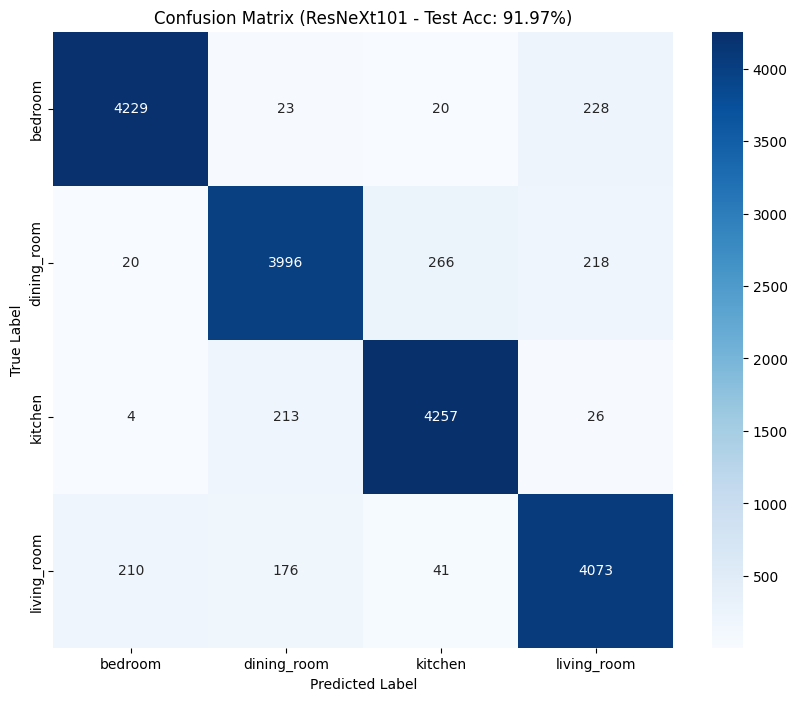


🚀 Project Completed Successfully!


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns # pip install seaborn
import numpy as np

# --- 1. Load Best Weights ---
# We load the weights that achieved the highest validation accuracy (~92.3%)
# This ensures we don't use the slightly overfitted weights from the very last epoch.
best_weights_path = "resnext101_lsun_stage2_best.h5"
print(f"📂 Loading best weights from: {best_weights_path}...")
model.load_weights(best_weights_path)

# --- 2. Run Predictions on Test Set ---
print("🚀 Running predictions on the Test Set (18,000 images)...")

# Reset generator to ensure alignment between predictions and labels
test_generator.reset()

# Predict
# This will output probabilities (e.g., [0.1, 0.8, 0.05, 0.05])
predictions = model.predict(test_generator, verbose=1)

# Convert probabilities to Class Indices (0, 1, 2, 3)
y_pred = np.argmax(predictions, axis=1)

# Get True Labels
y_true = test_generator.classes

# Get Class Names
class_names = list(test_generator.class_indices.keys())

# --- 3. Generate Metrics ---

# Calculate Standard Accuracy
errors = np.where(y_pred != y_true)[0]
accuracy = (1 - len(errors)/len(y_true)) * 100
print(f"\n✅ Final Test Set Accuracy: {accuracy:.2f}%")

# Detailed Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- 4. Plot Confusion Matrix ---
print("\n📉 Generating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (ResNeXt101 - Test Acc: {accuracy:.2f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n🚀 Project Completed Successfully!")

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# --- 1. Library Setup (Ensure image-classifiers is available) ---
try:
    from classification_models.tfkeras import Classifiers
except ImportError:
    print("⚠️ Library 'image-classifiers' not found. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "image-classifiers"])
    from classification_models.tfkeras import Classifiers

# --- 2. Configuration ---
IMG_SIZE = 256
NUM_CLASSES = 4
CLASS_LABELS = ['bedroom', 'dining_room', 'kitchen', 'living_room']
# Path to your best saved weights
WEIGHTS_PATH = 'resnext101_lsun_stage2_best.h5' 

# --- 3. Function to Reconstruct Model and Load Weights ---
def load_trained_model(weights_path):
    print(f"🏗️ Reconstructing ResNeXt101 architecture...")
    
    # Get the architecture and the specific preprocessing function
    ResNeXt101, preprocess_input = Classifiers.get('resnext101')
    
    # 1. Build Base (Same as training, but weights=None is fine as we load them later)
    base_model = ResNeXt101(
        input_shape=(IMG_SIZE, IMG_SIZE, 3), 
        weights=None, 
        include_top=False
    )
    
    # 2. Build Head (Must match training structure exactly)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # 3. Create Model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # 4. Load Weights
    print(f"📂 Loading weights from: {weights_path}")
    if os.path.exists(weights_path):
        model.load_weights(weights_path)
        print("✅ Weights loaded successfully.")
    else:
        raise FileNotFoundError(f"❌ Weights file not found at: {weights_path}")
        
    return model, preprocess_input

# --- 4. Prediction Function ---
def predict_image(image_path, model, preprocess_func):
    """
    Loads an image, applies specific preprocessing, and predicts class.
    """
    try:
        # Load and Resize
        img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        
        # Convert to Array
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        
        # Preprocess (Mean Subtraction)
        img_preprocessed = preprocess_func(img_batch)
        
        # Predict
        predictions = model.predict(img_preprocessed, verbose=0)
        predicted_class_idx = np.argmax(predictions)
        confidence = np.max(predictions)
        predicted_label = CLASS_LABELS[predicted_class_idx]
        
        # Visualize
        plt.figure(figsize=(6, 6))
        plt.imshow(image.load_img(image_path))
        plt.axis('off')
        plt.title(f"Pred: {predicted_label.upper()} ({confidence*100:.2f}%)")
        plt.show()
        
        print(f"✅ Prediction: {predicted_label}")
        print(f"📊 Confidence Scores: {dict(zip(CLASS_LABELS, np.round(predictions[0], 4)))}")
        
    except Exception as e:
        print(f"⚠️ Error processing image: {e}")

🏗️ Reconstructing ResNeXt101 architecture...
📂 Loading weights from: resnext101_lsun_stage2_best.h5
✅ Weights loaded successfully.


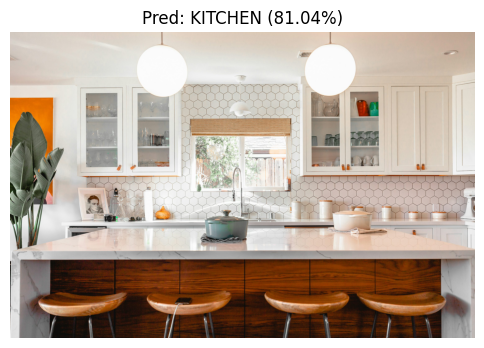

✅ Prediction: kitchen
📊 Confidence Scores: {'bedroom': np.float32(0.0), 'dining_room': np.float32(0.1895), 'kitchen': np.float32(0.8104), 'living_room': np.float32(1e-04)}


In [6]:
# ==========================================
# MAIN EXECUTION
# ==========================================
# 1. Load the model (Only needs to be done once)
try:
    model_inference, preprocess_input = load_trained_model(WEIGHTS_PATH)
    # 2. Example Usage
    test_image_path = "Kitchen_1.jpg"
    # Uncomment the lines below to test immediately if you have a path
    if os.path.exists(test_image_path):
        predict_image(test_image_path, model_inference, preprocess_input)
    else:
        print(f":information_source: Set 'test_image_path' to a valid image file to test.")
except Exception as e:
    print(f"\n:x: Setup Failed: {e}")